In [1]:
import os
import json
import subprocess
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
def read_dmat(file):
    h = np.loadtxt(file, max_rows=1, usecols=[0,1], dtype=np.int32)
    A = np.loadtxt(file, skiprows=1, usecols=[0], dtype=np.float32)
    A = np.reshape(A,(h[0],h[1]))
    return A

In [3]:
from dataclasses import dataclass, field

@dataclass
class Config:
    name: str
    tol: float = 1e-2
    kappa: float = 4e9
    solver: str = 'eigen-pcg-IC'
    mixed_vars: list = field(default_factory=lambda: ["mixed-stretch", "mixed-collision"])
    unmixed_vars: list = field(default_factory=lambda: [])


In [4]:
kappa =  1e10#2e9
solver = 'eigen-pcg-IC'
configs = [Config('FEM-pcg-ic-1e-1',1e-1, kappa,solver,[],['stretch','collision']),
           Config('FEM-pcg-ic-1e-2',1e-2, kappa,solver,[],['stretch','collision']),
           Config('FEM-pcg-ic-1e-4',1e-4, kappa,solver,[],['stretch','collision']),
           Config('FEM-pcg-ic-1e-8',1e-8, kappa,solver,[],['stretch','collision']),
           Config('FEM-cholmod',1e-8, kappa, 'cholmod',[],['stretch','collision']),
           Config('MFEM-pcg-ic-1e-1',1e-1, kappa,solver,['mixed-stretch','mixed-collision'],[]),
           Config('MFEM-pcg-ic-1e-2',1e-2, kappa,solver,['mixed-stretch','mixed-collision'],[]),
           Config('MFEM-pcg-ic-1e-4',1e-4, kappa,solver,['mixed-stretch','mixed-collision'],[]),
           Config('MFEM-pcg-ic-1e-8',1e-8, kappa,solver,['mixed-stretch','mixed-collision'],[]),
           Config('MFEM-cholmod',1e-8, kappa, 'cholmod',['mixed-stretch','mixed-collision'],[])
          ]
#linear_solvers=['eigen-pcg-diag','eigen-pcg-IC','minres-indefinite-block','subspace-amgcl']


In [5]:
ROOT = '/Users/trusty/mixed_fem/'
exe_path = os.path.join(ROOT,'build/bin/convergence')
scene_path = os.path.join(ROOT,'scenes/2D/')
#scenes = ['diving_board_deformed_fem.json']
scenes = ['soft_blocks.json']

In [6]:
# Load in the json file for the current scene
scene_file = os.path.join(scene_path,scenes[0])
with open(scene_file, 'r') as f:
    scene_json = json.load(f);

In [7]:
A = []
B = []
tmp_json = 'tmp.json'
timesteps = 40      # number of timesteps to run each trial for
newton_iters = 120

for (i,config) in enumerate(configs):
#for (i,kappa) in enumerate(kappas):
    
    # Modify scene description
    scene_json['kappa'] = config.kappa
    scene_json['linear_solver'] = config.solver
    scene_json['variables'] = config.unmixed_vars
    scene_json['mixed_variables'] = config.mixed_vars
    scene_json['max_newton_iterations'] = newton_iters
    scene_json['iterative_solver_tolerance'] = config.tol
    print('mixed', config.mixed_vars, ' variables', config.unmixed_vars, ' tol: ', config.tol)
    
    # Write current modified json to tmp file
    with open(tmp_json, 'w') as f:
        json.dump(scene_json, f, indent=4)
    
    # Run simulation
    ret=subprocess.run([exe_path,tmp_json,'-n',str(timesteps)],
                       stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    
    # Add data
    data = os.path.join(ROOT,'output/convergence.dmat')
    data = read_dmat(data)
    B.append(data)
    data = np.mean(data,axis=1)
    A.append(data)

mixed []  variables ['stretch', 'collision']  tol:  0.1
mixed []  variables ['stretch', 'collision']  tol:  0.01
mixed []  variables ['stretch', 'collision']  tol:  0.0001
mixed []  variables ['stretch', 'collision']  tol:  1e-08
mixed []  variables ['stretch', 'collision']  tol:  1e-08
mixed ['mixed-stretch', 'mixed-collision']  variables []  tol:  0.1
mixed ['mixed-stretch', 'mixed-collision']  variables []  tol:  0.01
mixed ['mixed-stretch', 'mixed-collision']  variables []  tol:  0.0001
mixed ['mixed-stretch', 'mixed-collision']  variables []  tol:  1e-08
mixed ['mixed-stretch', 'mixed-collision']  variables []  tol:  1e-08


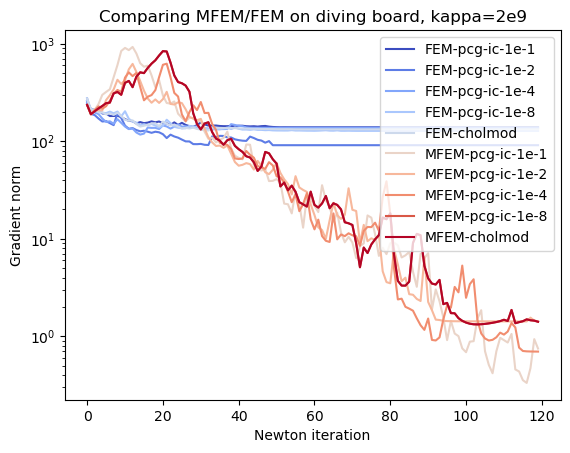

In [8]:

colors = plt.cm.coolwarm(np.linspace(0,1,len(A)))

for i in range(len(A)):
    p = plt.plot(np.arange(0,len(A[i])),A[i],color=colors[i])
    p[0].set_label(configs[i].name)

plt.xlabel('Newton iteration')
plt.ylabel('Gradient norm')
plt.yscale('log')    
plt.title('Comparing MFEM/FEM on diving board, kappa=2e9')
plt.legend(loc='upper right')


plt.show()

(120, 40)


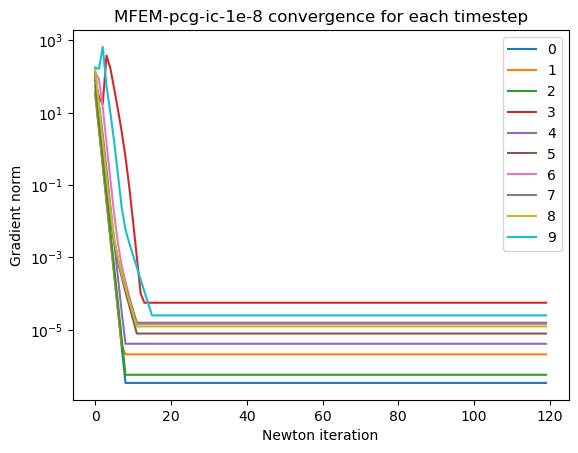

[[3.3677391e+01 3.7735157e+01 5.6568237e+01 ... 2.0646153e+02
  2.0155087e+02 2.0752199e+02]
 [3.3684072e+00 3.7735021e+00 5.6568236e+00 ... 3.0176273e+02
  2.6107510e+02 2.7226083e+02]
 [3.3686733e-01 3.7734896e-01 5.6568235e-01 ... 4.2029523e+02
  2.7701288e+02 2.8903461e+02]
 ...
 [3.3699610e-07 2.0753960e-06 5.6568234e-07 ... 5.2466097e+00
  1.7650664e+00 1.8360564e+00]
 [3.3699610e-07 2.0753960e-06 5.6568234e-07 ... 5.2466068e+00
  1.7650467e+00 1.8360604e+00]
 [3.3699610e-07 2.0753960e-06 5.6568234e-07 ... 5.2466044e+00
  1.7650309e+00 1.8360659e+00]]


In [12]:
idx = 8
niters = 10

data = B[idx]
print(data.shape)
for i in range(min(data.shape[1],niters)):
    #if (i < 30):
    #    continue;
    plt.plot(np.arange(0,data.shape[0]), data[:,i])
    plt.xlabel('Newton iteration')
    plt.ylabel('Gradient norm')
    plt.yscale('log')
#plt.legend(tolerances)
plt.title(str(configs[idx].name) + ' convergence for each timestep')
plt.legend(np.arange(0,min(data.shape[1],niters)))
plt.show()
print(data)

In [10]:
os.remove(tmp_json)

In [11]:
# Specify maximum newtons of force
# Specify initial force
# Specify target speed 
# Specify amount of displacement
# Specify duration to pause at flip point
# Specify whether to flip

# Increase force to attempt to match target speed 
# Once at maximum, pause, then flip 

# -- Label graphs with preconditioner
# Try Vanilla IPC on dragon
# Edge-edge smoothing for MFEM in 3D
# -- Bunch of cubes (that are soft)
# -- (Try to use the same kappa as both, but if not we may have to do more qualitvative comparisons)
# -- Make sure cholmod gives superior results to iterative solvers and the vanilla IPC at least eventually converges
# Figure out where 3D is crashing (MAYBE?)